In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [41]:
YEAR = 2015
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / f"reanalyze_csvs_{YEAR}.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [42]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
f5,3725,1,f5,3725
mmirs,4201,1,mmirs,4201
oldf9,2955,1,oldf9,2955


In [43]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[np.isfinite(data['vlt_seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['exptime'] >= 15]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [44]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
0,2015-01-07T03:04:55,oldf9,auto_wfs_0000.fits,7.0,1.15,33.44,60.69,11.25,11.0,10.7,...,296.008827,250.986334,1.656856,1.801787,1.696758,1.845179,0.094739,11.669165,2700.721565,3305.055551
1,2015-01-07T03:05:13,oldf9,auto_wfs_0001.fits,14.0,1.15,33.38,60.73,11.25,11.0,10.7,...,297.004127,252.006629,1.539282,1.673928,1.575980,1.713837,0.065248,11.050818,2224.434896,1653.290498
2,2015-01-07T03:05:22,oldf9,auto_wfs_0002.fits,7.0,1.15,33.35,60.75,11.25,11.0,10.7,...,292.010699,254.986990,1.786337,1.942595,1.699862,1.848555,0.015102,12.346193,2712.778332,3521.119763
3,2015-01-07T03:05:43,oldf9,auto_wfs_0003.fits,14.0,1.15,33.29,60.79,11.25,11.0,10.7,...,298.007926,249.989935,1.677720,1.824476,1.714108,1.864047,0.074745,11.778543,2219.961620,2238.757979
4,2015-01-07T03:06:35,oldf9,auto_wfs_0004.fits,7.0,1.14,30.85,60.95,11.25,10.9,10.7,...,296.984665,251.011052,2.436760,2.636062,1.448957,1.567467,0.395539,15.617967,1996.138155,3141.055850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2015-12-22T03:31:46,mmirs,mmirs_wfs_rename_0022.fits,95.0,1.16,14.45,59.88,2.83,2.8,2.6,...,227.495752,244.502842,1.972531,2.156248,1.731728,1.893017,0.072603,7.962705,1520.649481,1621.737118
7,2015-12-22T03:33:24,mmirs,mmirs_wfs_rename_0025.fits,30.0,1.16,14.08,59.96,2.73,2.8,2.7,...,227.995607,245.499187,2.182284,2.385537,1.904632,2.082025,0.057945,8.597689,1712.286209,1677.041472
8,2015-12-22T03:33:56,mmirs,mmirs_wfs_rename_0026.fits,30.0,1.15,13.96,59.99,2.78,2.8,2.7,...,227.994487,236.001902,2.243470,2.439714,1.953750,2.124651,0.069455,8.746856,1231.618761,1686.529849
9,2015-12-22T03:34:28,mmirs,mmirs_wfs_rename_0027.fits,30.0,1.15,13.84,60.01,2.73,2.8,2.7,...,228.002560,236.999634,2.174192,2.364377,1.886098,2.051082,0.058544,8.539338,1388.775204,1699.540122


In [45]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))
fixed = fixed[(fixed.index >= f"{YEAR}-01-01") & (fixed.index < f"{YEAR+1}-01-01")]

<Figure size 800x500 with 0 Axes>

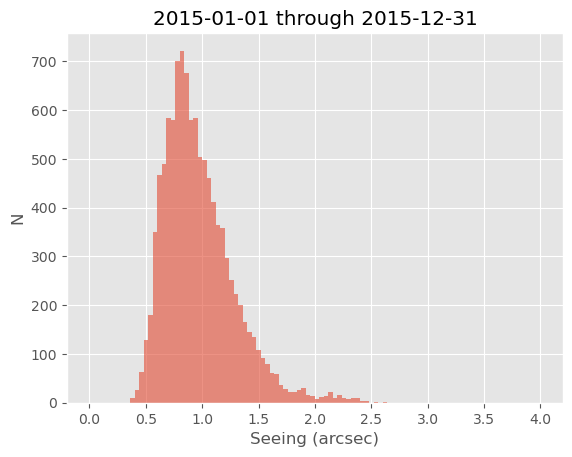

In [46]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='vlt_seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [47]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.3892121349226943 0.19315318804602175 0.7210164201468899


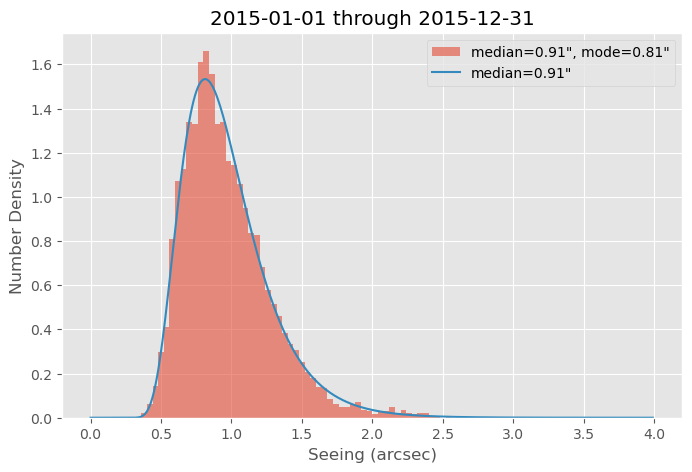

In [48]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig(f"{YEAR}_allyear.png")
plt.show()

/Users/tim/conda/envs/mmtwfs/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tim/conda/envs/mmtwfs/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


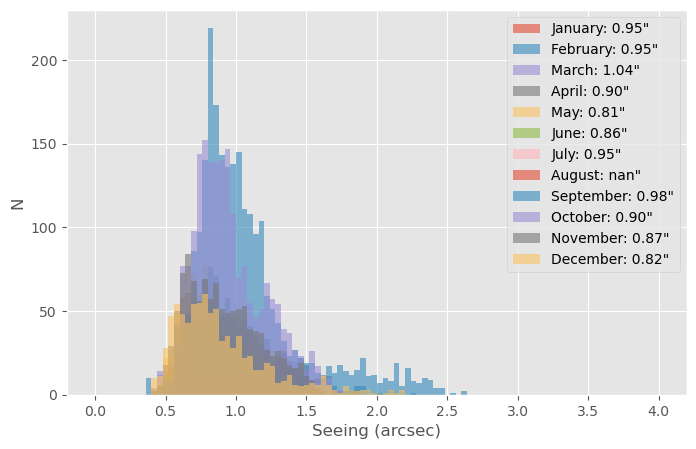

In [49]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months["January"] = fixed.loc[f"{YEAR}-01"]
months["February"] = fixed.loc[f"{YEAR}-02"]
months["March"] = fixed.loc[f"{YEAR}-03"]
months["April"] = fixed.loc[f"{YEAR}-04"]
months["May"] = fixed.loc[f"{YEAR}-05"]
months["June"] = fixed.loc[f"{YEAR}-06"]
months["July"] = fixed.loc[f"{YEAR}-07"]
months["August"] = fixed.loc[f"{YEAR}-08"]
months["September"] = fixed.loc[f"{YEAR}-09"]
months["October"] = fixed.loc[f"{YEAR}-10"]
months["November"] = fixed.loc[f"{YEAR}-11"]
months["December"] = fixed.loc[f"{YEAR}-12"]
for m in months:
    plt.hist(months[m]["vlt_seeing"], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]["vlt_seeing"]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig(f"{YEAR}_monthly.png")
plt.show()

In [50]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

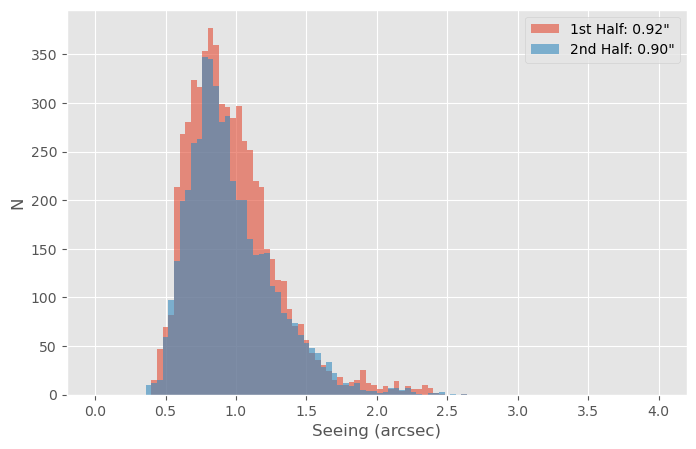

In [51]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig(f"{YEAR}_1st2nd.png")
plt.show()

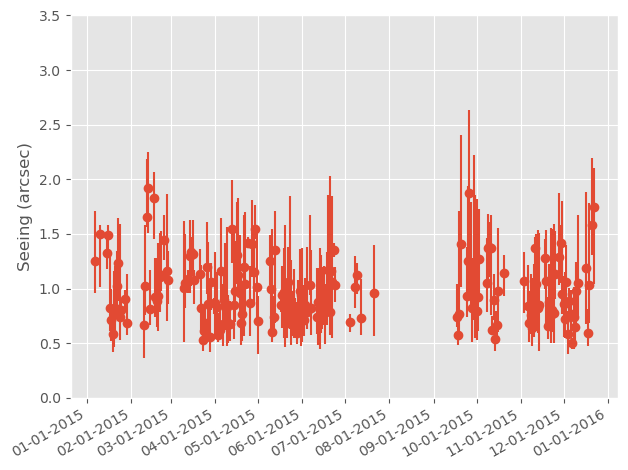

In [52]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig(f"{YEAR}_nightly.png")
plt.show()

In [53]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
ellipticity_data = [np.array(fixed.loc[date]['ellipticity']) for date in date_list]
clean_data = {}
clean_ellipticity = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
for d, arr in zip(date_list, ellipticity_data):
    if len(arr) > 0:
        clean_ellipticity[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

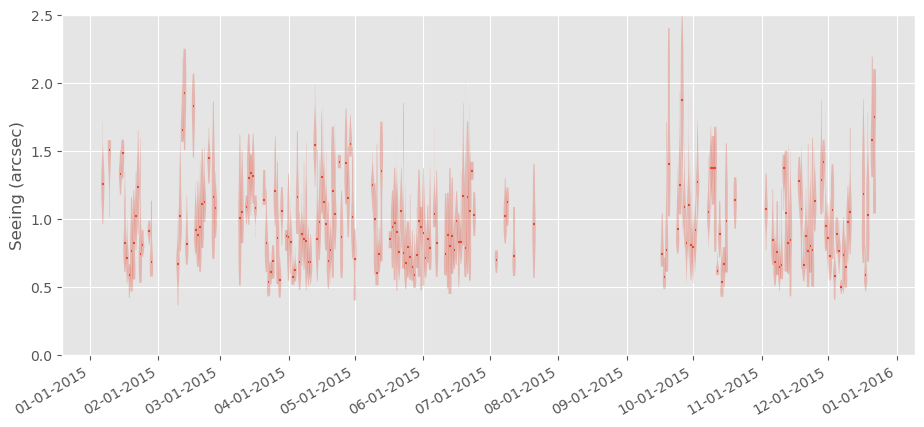

In [54]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    ax.set_ylim(0.0, 2.5)
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin.png")
    plt.show()

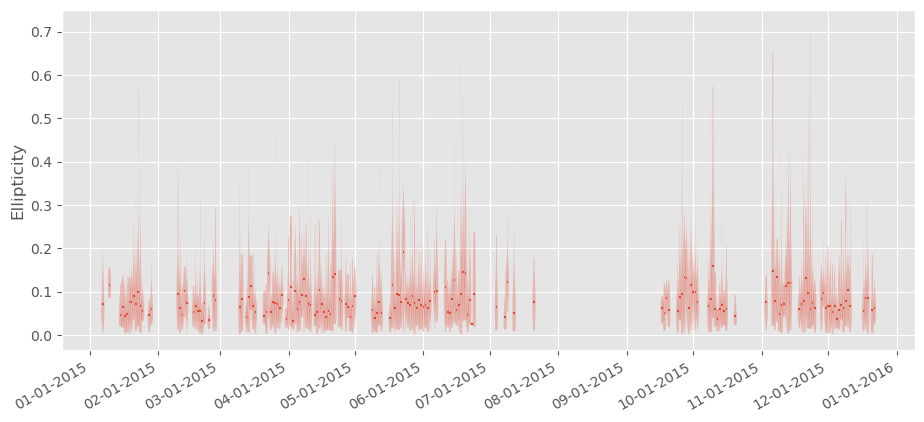

In [55]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_ellipticity.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Ellipticity")
    plt.savefig(f"{YEAR}_ellip_violin.png")
    plt.show()

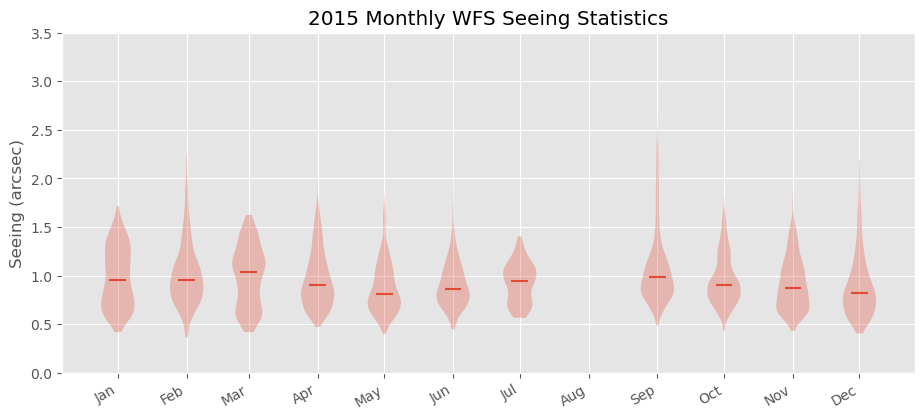

In [57]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin_monthly.png")
    plt.title(f"{YEAR} Monthly WFS Seeing Statistics")
    plt.show()

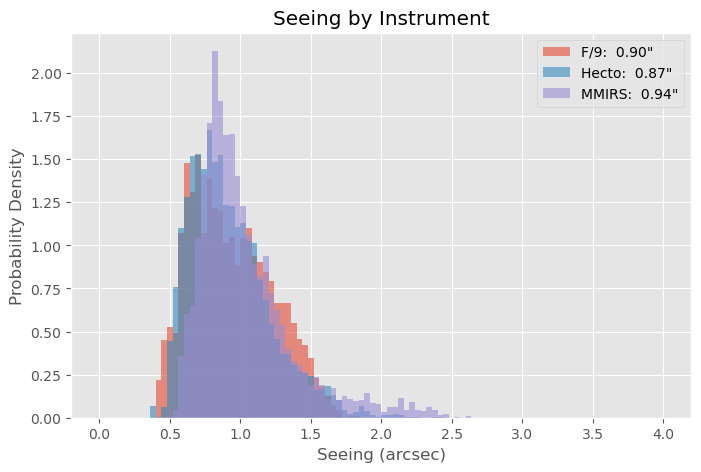

In [58]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medo9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'oldf9'])
    medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'oldf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {medo9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig(f"per_instrument_{YEAR}.png")
plt.show()

In [59]:
oldf9 = fixed[fixed['wfs'] == 'oldf9']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [60]:
oldf9_dates = sorted(list(set(oldf9.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
hecto_dates, oldf9_dates, mmirs_dates

(['2015-02-10',
  '2015-02-11',
  '2015-02-12',
  '2015-02-13',
  '2015-02-14',
  '2015-02-17',
  '2015-02-18',
  '2015-02-19',
  '2015-02-20',
  '2015-02-21',
  '2015-02-22',
  '2015-02-24',
  '2015-02-26',
  '2015-02-27',
  '2015-03-31',
  '2015-04-01',
  '2015-04-02',
  '2015-04-03',
  '2015-04-04',
  '2015-04-05',
  '2015-04-06',
  '2015-04-07',
  '2015-04-08',
  '2015-04-09',
  '2015-04-10',
  '2015-04-11',
  '2015-04-13',
  '2015-04-14',
  '2015-04-15',
  '2015-04-16',
  '2015-04-17',
  '2015-04-18',
  '2015-04-19',
  '2015-04-20',
  '2015-04-21',
  '2015-04-22',
  '2015-05-19',
  '2015-05-20',
  '2015-05-21',
  '2015-05-22',
  '2015-05-23',
  '2015-05-24',
  '2015-05-25',
  '2015-05-26',
  '2015-05-27',
  '2015-05-28',
  '2015-05-29',
  '2015-05-30',
  '2015-05-31',
  '2015-06-01',
  '2015-06-02',
  '2015-06-03',
  '2015-06-04',
  '2015-06-06',
  '2015-06-07',
  '2015-06-19',
  '2015-06-20',
  '2015-06-21',
  '2015-06-22',
  '2015-06-23',
  '2015-06-24',
  '2015-07-04',
  '2015-

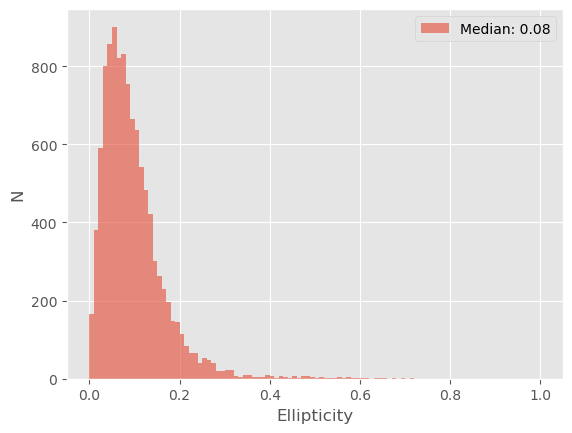

In [61]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.savefig(f"ellipticity_{YEAR}.png")
plt.show()


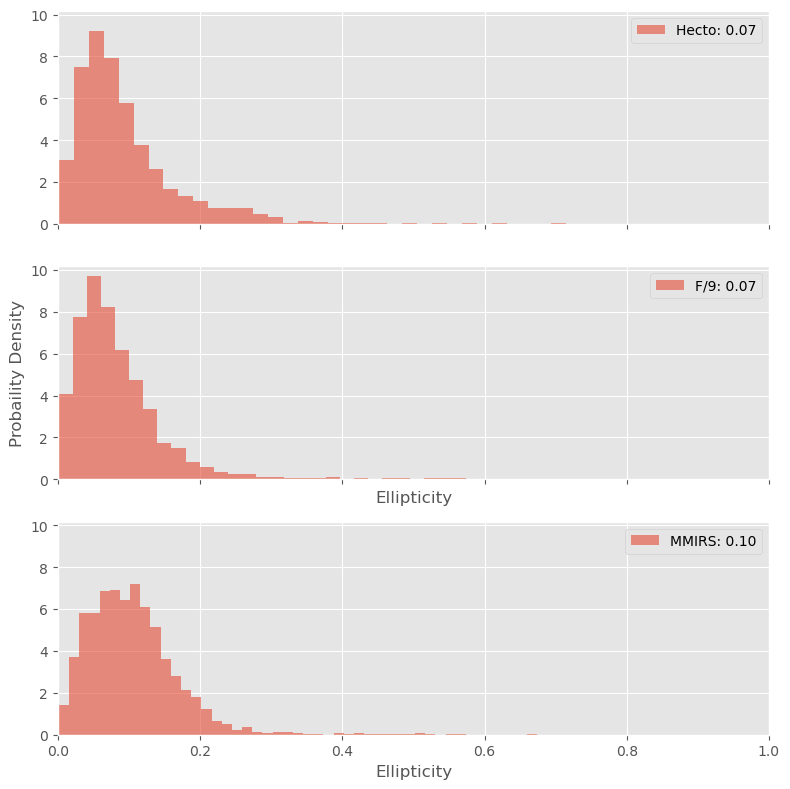

In [62]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "knuth"

    hist(hecto['ellipticity'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Hecto: {np.median(hecto['ellipticity']):.2f}"])
    ax[0].set_xlim(0, 1)

    hist(oldf9['ellipticity'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True, label=f"F/9: {np.median(oldf9['ellipticity']):.2f}")
    ax[1].legend()
    ax[1].set_xlim(0, 1)
    ax[1].set_xlabel("Ellipticity")
    ax[1].set_ylabel("Probaility Density")

    hist(mmirs['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"MMIRS: {np.median(mmirs['ellipticity']):.2f}"])
    ax[2].set_xlim(0, 1)
    ax[2].set_xlabel("Ellipticity")

    plt.tight_layout()
    plt.savefig(f"{YEAR}_ellip_vs_inst.png")
    plt.show()

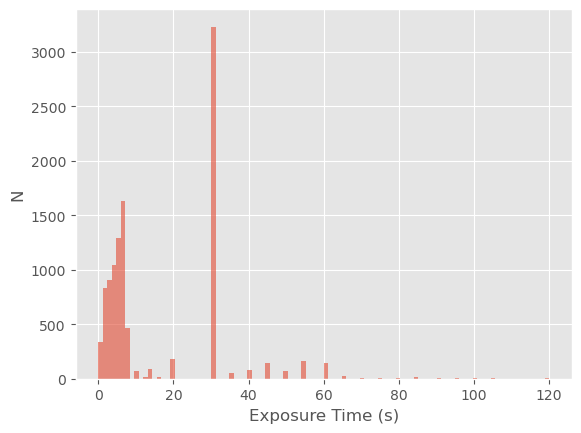

In [64]:
plt.hist(fixed['exptime'], bins=100, range=(0.0, 120.0), alpha=0.6)
plt.xlabel("Exposure Time (s)")
plt.ylabel("N")
plt.savefig(f"exptime_{YEAR}.png")
plt.show()